In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch

import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

In [2]:
train_path = '/opt/ml/input/data/train'
train_image_dir_path = os.path.join(train_path, 'images')

In [3]:
def search(dirname, result):
    try:
        filenames = os.listdir(dirname)
        for filename in filenames:
            if filename[0] == ".":
                continue
            full_filename = os.path.join(dirname, filename)
            if os.path.isdir(full_filename):
                search(full_filename, result)
            else:
                ext = os.path.splitext(full_filename)[-1]
                if ext:
                    result.append(full_filename)
    except PermissionError:
        pass

In [4]:
all_path = []
search(train_image_dir_path, all_path)

In [5]:
len(all_path)

18900

In [6]:
all_path[:10]

['/opt/ml/input/data/train/images/006730_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask5.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/normal.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask4.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask3.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask2.jpg',
 '/opt/ml/input/data/train/images/006730_male_Asian_19/mask1.jpg',
 '/opt/ml/input/data/train/images/006959_male_Asian_19/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/006959_male_Asian_19/mask5.jpg',
 '/opt/ml/input/data/train/images/006959_male_Asian_19/normal.jpg']

In [7]:
exts = []
for i in all_path:
    ext = os.path.splitext(i)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts)

['.jpg', '.jpeg', '.png']


In [8]:
all_path = sorted(all_path)

In [9]:
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:]
    info = info.split('_')
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 3
    
    if gender == 'female':
        label += 3
    if 30 <= age and age < 60:
        label += 1
    elif age >= 60:
        label +=2
    return label

In [10]:
train_path_label = pd.DataFrame(all_path, columns = ['path'])
train_path_label['label'] = train_path_label['path'].map(lambda x : labeling(x))
train_path_label

,path,label
0,/opt/ml/input/data/train/images/000001_female_...,10
1,/opt/ml/input/data/train/images/000001_female_...,4
2,/opt/ml/input/data/train/images/000001_female_...,4
3,/opt/ml/input/data/train/images/000001_female_...,4
4,/opt/ml/input/data/train/images/000001_female_...,4
...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0
18896,/opt/ml/input/data/train/images/006959_male_As...,0
18897,/opt/ml/input/data/train/images/006959_male_As...,0
18898,/opt/ml/input/data/train/images/006959_male_As...,0


In [11]:
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.x = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform
    def __getitem__(self, index):
        image = Image.open(self.x.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)
    
    def __len__(self):
        return len(self.x)

In [12]:
transform = transforms.Compose([
    Resize((512,384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean = (0.5,0.5,0.5), std = (0.2,0.2,0.2)),])

In [13]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_path_label, 
                                test_size = 0.1,
                                shuffle = True,
                                stratify = train_path_label['label'],
                                random_state = 34)

In [14]:
train.shape, valid.shape

((17010, 2), (1890, 2))

In [15]:
BATCH_SIZE = 64

In [16]:
train_dataset = CustomDataset(train, transform)
train_dataloader = DataLoader(train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

In [17]:
valid_dataset = CustomDataset(valid, transform)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

In [18]:
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

In [19]:
resnet34 = torchvision.models.resnet34(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /opt/ml/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [20]:
import math
OUTPUT_CLASS_NUM = 18
resnet34.fc = torch.nn.Linear(in_features = 512, out_features = OUTPUT_CLASS_NUM, bias = True)
torch.nn.init.xavier_uniform_(resnet34.fc.weight)
stdv = 1. / math.sqrt(resnet34.fc.weight.size(1))
resnet34.fc.bias.data.uniform_(-stdv, stdv)

resnet34.fc.weight.shape[0]

18

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [22]:
resnet34.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
LEARNING_RATE = 0.0001
NUM_EPOCH = 20
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet34.parameters(), lr = LEARNING_RATE)

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader}

In [24]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in range(NUM_EPOCH):
    for phase in ["train", "test"]:
        running_loss = 0
        running_acc = 0
        if phase == "train":
            resnet34.train()
        elif phase == "test":
            resnet34.eval()
        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == "train"):
                logits = resnet34(images)
                _, preds = torch.max(logits, 1)
                loss = loss_fn(logits, labels)
                
                if phase == "train":
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * images.size(0)
            running_acc += torch.sum(preds == labels.data)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss:.3f}, 평균 Accuracy : {epoch_acc:.3f}")
        if phase == "test" and best_test_accuracy < epoch_acc:
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss:
            best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss : {best_test_loss}")

현재 epoch-0의 train-데이터 셋에서 평균 Loss : 0.393, 평균 Accuracy : 0.879
현재 epoch-0의 test-데이터 셋에서 평균 Loss : 0.153, 평균 Accuracy : 0.949
현재 epoch-1의 train-데이터 셋에서 평균 Loss : 0.061, 평균 Accuracy : 0.981
현재 epoch-1의 test-데이터 셋에서 평균 Loss : 0.159, 평균 Accuracy : 0.946
현재 epoch-2의 train-데이터 셋에서 평균 Loss : 0.031, 평균 Accuracy : 0.991
현재 epoch-2의 test-데이터 셋에서 평균 Loss : 0.060, 평균 Accuracy : 0.980
현재 epoch-3의 train-데이터 셋에서 평균 Loss : 0.018, 평균 Accuracy : 0.995
현재 epoch-3의 test-데이터 셋에서 평균 Loss : 0.040, 평균 Accuracy : 0.990
현재 epoch-4의 train-데이터 셋에서 평균 Loss : 0.018, 평균 Accuracy : 0.995
현재 epoch-4의 test-데이터 셋에서 평균 Loss : 0.094, 평균 Accuracy : 0.971
현재 epoch-5의 train-데이터 셋에서 평균 Loss : 0.017, 평균 Accuracy : 0.995
현재 epoch-5의 test-데이터 셋에서 평균 Loss : 0.102, 평균 Accuracy : 0.972
현재 epoch-6의 train-데이터 셋에서 평균 Loss : 0.026, 평균 Accuracy : 0.992
현재 epoch-6의 test-데이터 셋에서 평균 Loss : 0.086, 평균 Accuracy : 0.979
현재 epoch-7의 train-데이터 셋에서 평균 Loss : 0.016, 평균 Accuracy : 0.995
현재 epoch-7의 test-데이터 셋에서 평균 Loss : 0.076, 평균 Accuracy : 0.978


In [25]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0,0
        model.eval()
        for batch_in, batch_out in data_iter:
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1)
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct/n_total)
    return val_accr

In [26]:
func_eval(resnet34, valid_dataloader, device)

0.9978835978835979

In [27]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred,1)
            
            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns = ['path','pred','target'])
    return result

In [28]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle = False)
check_eval_df = check_eval(valid, valid_testing_dataloader, resnet34, device)
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/006952_male_As...,0,0
1,/opt/ml/input/data/train/images/003235_female_...,6,6
2,/opt/ml/input/data/train/images/005052_male_As...,7,7
3,/opt/ml/input/data/train/images/000023_female_...,4,4
4,/opt/ml/input/data/train/images/003074_female_...,3,3
...,...,...,...
1885,/opt/ml/input/data/train/images/003676_male_As...,1,1
1886,/opt/ml/input/data/train/images/006163_female_...,3,3
1887,/opt/ml/input/data/train/images/006215_male_As...,0,0
1888,/opt/ml/input/data/train/images/006244_male_As...,3,3


In [29]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/001740_female_...,10,4
1,/opt/ml/input/data/train/images/001064_female_...,6,7
2,/opt/ml/input/data/train/images/004489_male_As...,0,6
3,/opt/ml/input/data/train/images/001042_male_As...,6,3


In [30]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
f1_score(check_eval_df['target'], check_eval_df['pred'], average='macro')

0.9978382690055593

In [32]:
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/006952_male_As...,0,0
1,/opt/ml/input/data/train/images/003235_female_...,6,6
2,/opt/ml/input/data/train/images/005052_male_As...,7,7
3,/opt/ml/input/data/train/images/000023_female_...,4,4
4,/opt/ml/input/data/train/images/003074_female_...,3,3
...,...,...,...
1885,/opt/ml/input/data/train/images/003676_male_As...,1,1
1886,/opt/ml/input/data/train/images/006163_female_...,3,3
1887,/opt/ml/input/data/train/images/006215_male_As...,0,0
1888,/opt/ml/input/data/train/images/006244_male_As...,3,3


In [33]:
print('1')

1


In [51]:
test_path = '/opt/ml/input/data/eval'
test_image_dir_path = os.path.join(test_path, 'images')
test_path_df = pd.read_csv(test_path+'/info.csv')
test_path_df

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,0
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,0
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,0
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,0
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,0
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,0
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,0
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,0
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,0


In [52]:
resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [53]:
print(test_path_df['ImageID'][0])

cbc5c6e168e63498590db46022617123f1fe1268.jpg


In [61]:
img = transform(img).to(device)
img = torch.unsqueeze(img, 0)
prediction = F.softmax(resnet34(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction])

tensor(10, device='cuda:0')


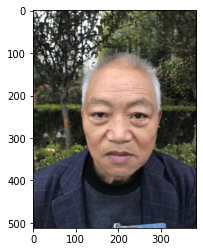

In [62]:
img = Image.open(os.path.join(test_image_dir_path, test_path_df['ImageID'][0])) 
plt.imshow(img)
plt.show()

In [79]:
def myPredict(df,model,transform=transform):
    predict_list = []
    for i in range(len(df)):
        img = Image.open(os.path.join(test_image_dir_path, test_path_df['ImageID'][i]))
        img = transform(img).to(device)
        img = torch.unsqueeze(img,0)
        prediction = F.softmax(model(img), dim=1)
        prediction = prediction.argmax()
        predict_list.append(int(prediction))
    return predict_list
predict_df = myPredict(test_path_df, resnet34, transform)

In [80]:
print(predict_df)

[4, 1, 4, 4, 3, 0, 7, 4, 4, 3, 4, 3, 6, 3, 0, 4, 1, 1, 7, 4, 3, 1, 1, 3, 1, 0, 7, 1, 1, 0, 0, 4, 3, 4, 1, 0, 3, 7, 4, 0, 1, 1, 7, 3, 4, 1, 4, 2, 0, 1, 4, 9, 4, 1, 1, 10, 1, 0, 3, 1, 1, 1, 1, 6, 1, 0, 9, 4, 1, 5, 7, 3, 2, 1, 1, 0, 4, 1, 4, 4, 1, 1, 0, 1, 0, 7, 3, 7, 4, 1, 3, 10, 1, 1, 0, 1, 1, 2, 10, 0, 10, 1, 1, 1, 0, 3, 1, 3, 4, 4, 0, 7, 0, 0, 4, 4, 10, 4, 3, 3, 4, 9, 10, 5, 6, 1, 1, 4, 0, 4, 4, 0, 7, 3, 3, 4, 1, 4, 0, 6, 1, 1, 3, 0, 0, 1, 9, 4, 0, 2, 1, 4, 4, 3, 4, 7, 3, 0, 6, 6, 3, 6, 4, 7, 0, 4, 4, 3, 1, 1, 4, 4, 1, 7, 7, 3, 3, 1, 3, 4, 1, 0, 1, 7, 6, 0, 4, 9, 7, 8, 4, 4, 0, 4, 0, 3, 3, 4, 3, 6, 4, 0, 0, 3, 2, 3, 10, 4, 0, 4, 7, 3, 1, 6, 1, 4, 7, 1, 3, 0, 4, 4, 1, 3, 0, 1, 1, 4, 0, 3, 1, 5, 4, 0, 8, 3, 1, 0, 4, 4, 4, 1, 0, 6, 6, 1, 0, 1, 3, 0, 3, 7, 7, 3, 4, 0, 0, 0, 4, 2, 1, 4, 0, 1, 1, 6, 1, 9, 7, 0, 1, 1, 9, 2, 3, 0, 1, 6, 2, 4, 1, 5, 7, 0, 5, 3, 1, 4, 0, 7, 3, 6, 1, 0, 4, 4, 0, 3, 4, 4, 4, 7, 6, 1, 0, 1, 6, 0, 1, 1, 0, 4, 0, 7, 0, 2, 0, 0, 1, 0, 10, 4, 1, 9, 3, 3, 0, 3, 5, 0, 3

In [78]:
print(int(predict_df[0]))

4


In [81]:
test_path_df['ans'] = predict_df
test_path_df

,ImageID,ans
0,cbc5c6e168e63498590db46022617123f1fe1268.jpg,4
1,0e72482bf56b3581c081f7da2a6180b8792c7089.jpg,1
2,b549040c49190cedc41327748aeb197c1670f14d.jpg,4
3,4f9cb2a045c6d5b9e50ad3459ea7b791eb6e18bc.jpg,4
4,248428d9a4a5b6229a7081c32851b90cb8d38d0c.jpg,3
...,...,...
12595,d71d4570505d6af8f777690e63edfa8d85ea4476.jpg,1
12596,6cf1300e8e218716728d5820c0bab553306c2cfd.jpg,4
12597,8140edbba31c3a824e817e6d5fb95343199e2387.jpg,9
12598,030d439efe6fb5a7bafda45a393fc19f2bf57f54.jpg,1


In [82]:
test_path_df.to_csv('Resnet34.csv')

In [ ]:
def data_random_print(df, num = 5):
    